In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 정상데이터 불러오기
normal_df = pd.read_csv('/content/drive/My Drive/인공지능2020_2조/Normal.csv')
normal_df.head()

,Normal
0,-0.049316
1,-0.019775
2,-0.045898
3,-0.059082
4,-0.036377


In [ ]:
# 비정상데이터
abnormal_df = pd.read_csv('/content/drive/My Drive/인공지능2020_2조/Abnormal.csv', usecols=['Abnormal'])

In [ ]:
abnormal_df.head()

,Abnormal
0,0.010010
1,-0.034668
2,-0.000916
3,-0.046936
4,-0.009277


In [ ]:
normal_df.shape, abnormal_df.shape

((101825, 1), (101865, 1))

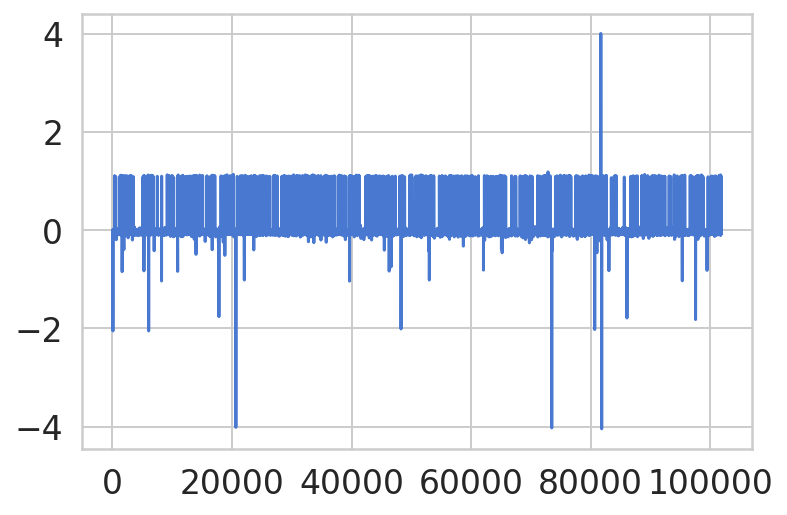

In [ ]:
# 정상 데이터 그래프로 확인
plt.plot(normal_df)

# 너무 튀는 데이터는 무시할 것 -> 전처리 필요  => 남길 데이터 범위? -0.1 ~ 1.1 사이로 변경

In [ ]:
normal_df['scaled']=normal_df.Normal.map(lambda x : 1.1 if x > 1.1 else x)

# map(lambda x: str(x) if x % 3 == 0 else x, a)

In [ ]:
normal_df['scaled']=normal_df.scaled.map(lambda x : -0.1 if x < -0.1 else x)

In [ ]:
normal_df.scaled.max()

1.1

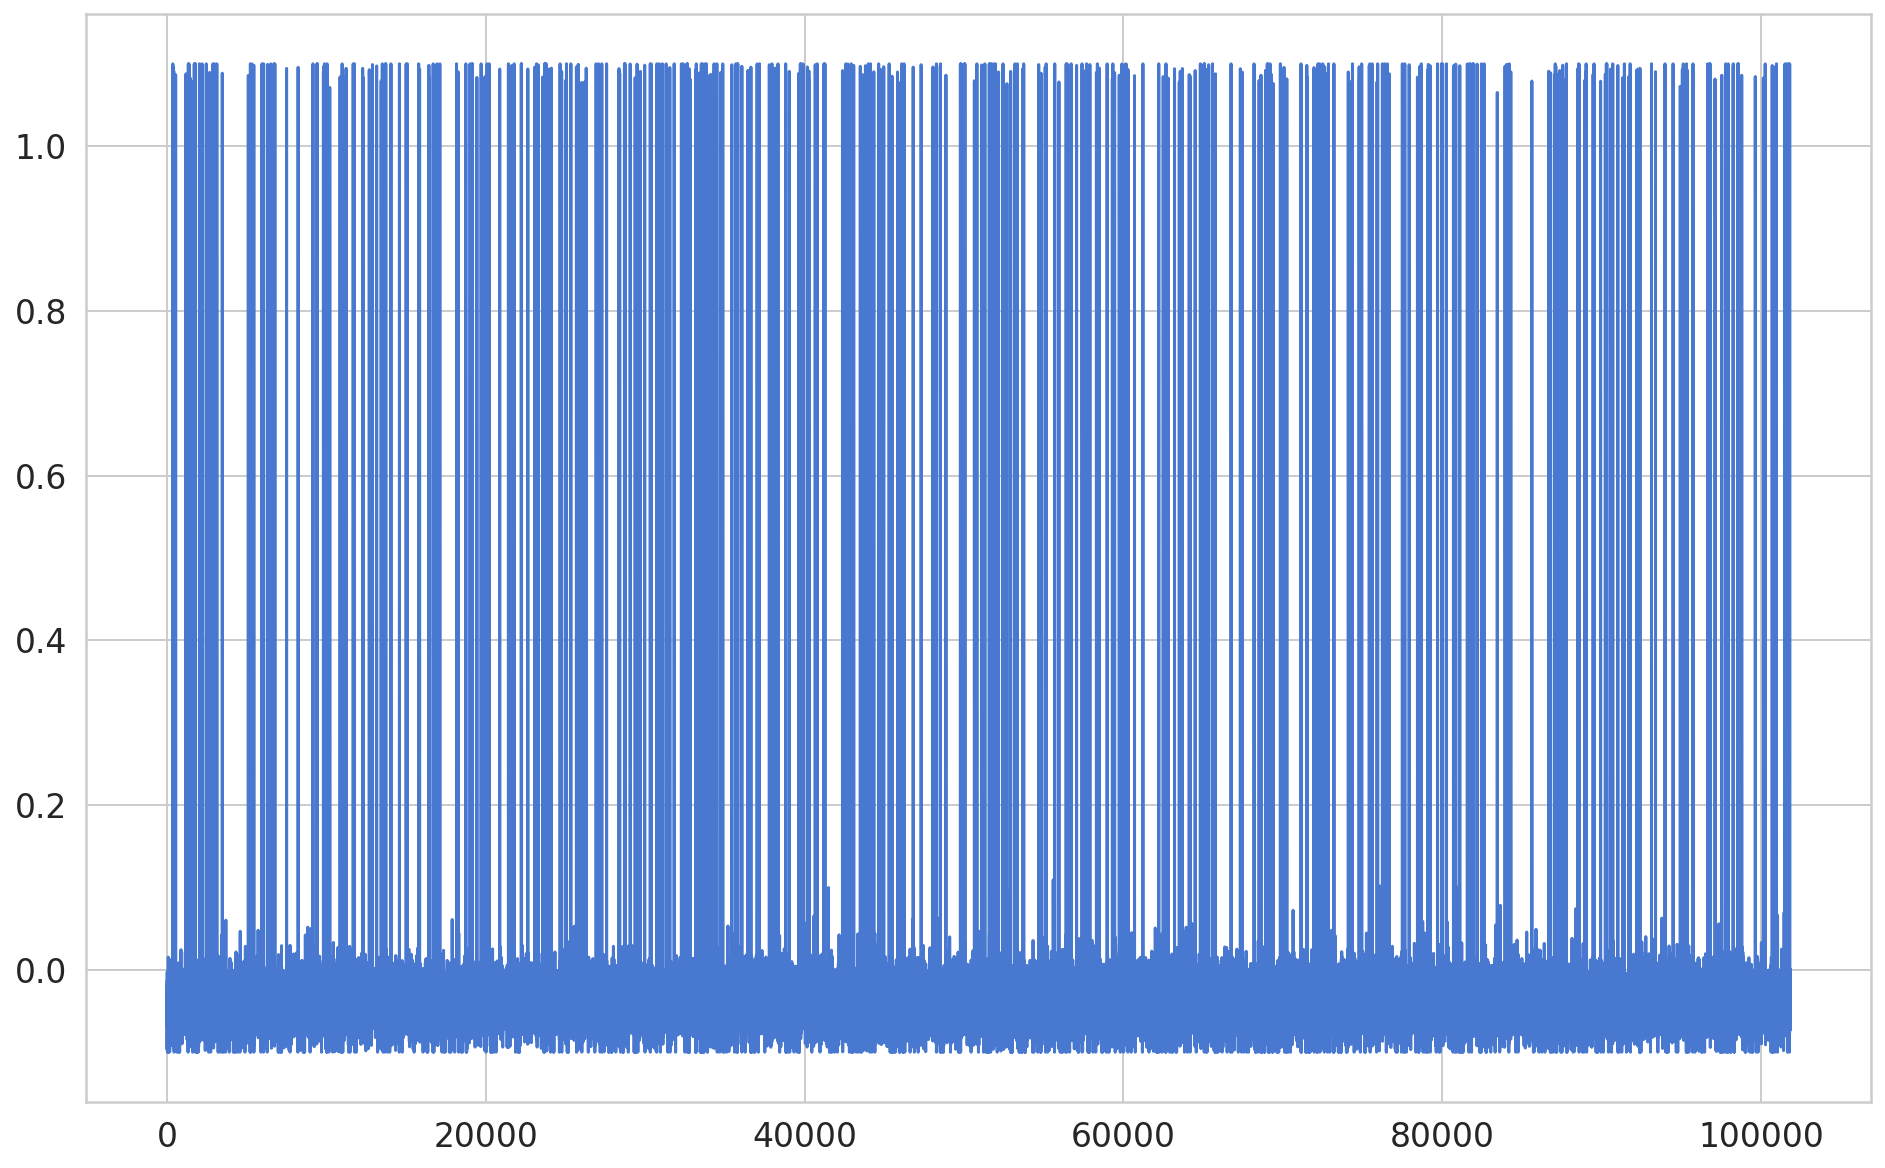

In [ ]:
# 정규화한 정상 데이터
plt.plot(normal_df.scaled)

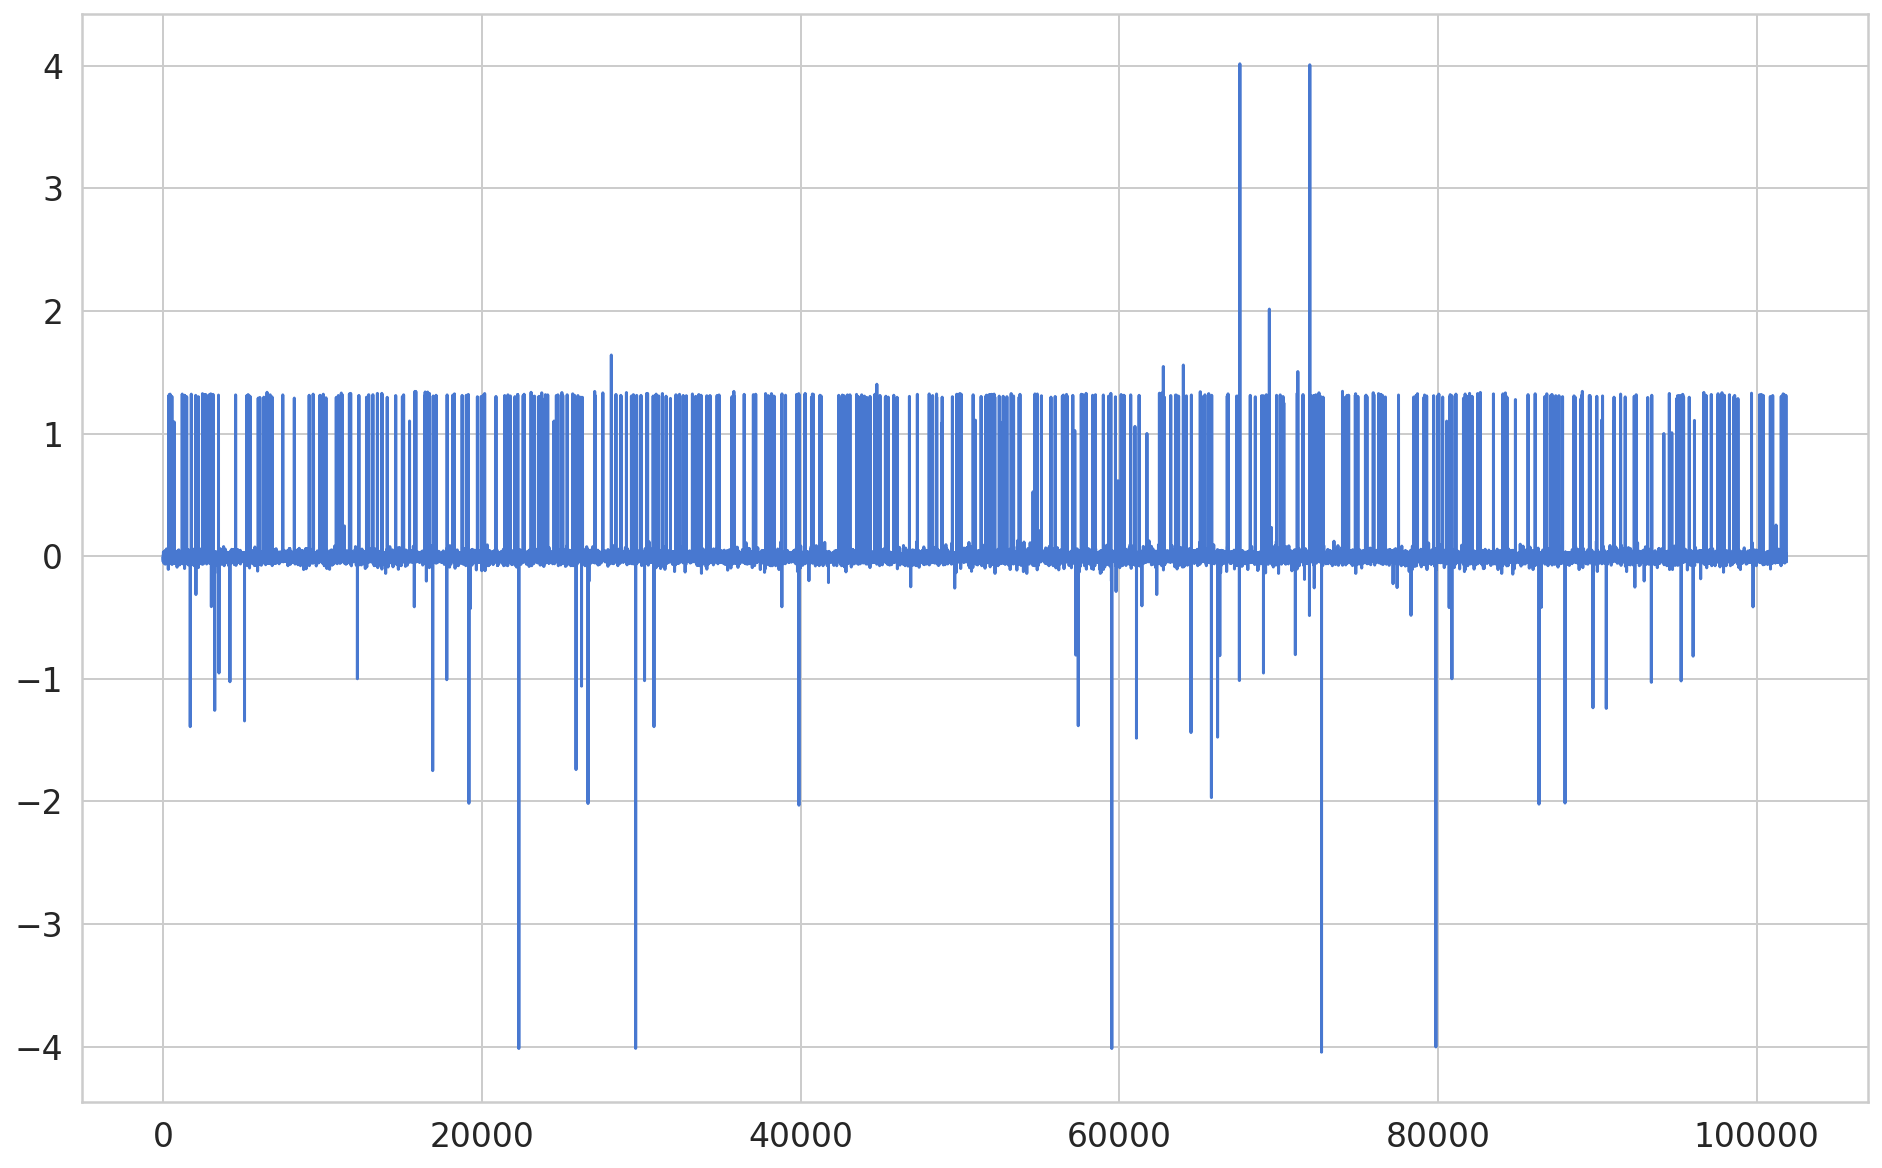

In [ ]:
# 비정상 데이터 확인
plt.plot(abnormal_df)

In [ ]:
# 비정상데이터 -0.5 ~ 1.5 범위로 정규화
abnormal_df['scaled']=abnormal_df.Abnormal.map(lambda x : 1.5 if x > 1.5 else x)
abnormal_df['scaled']=abnormal_df.scaled.map(lambda x : -0.5 if x < -0.5 else x)

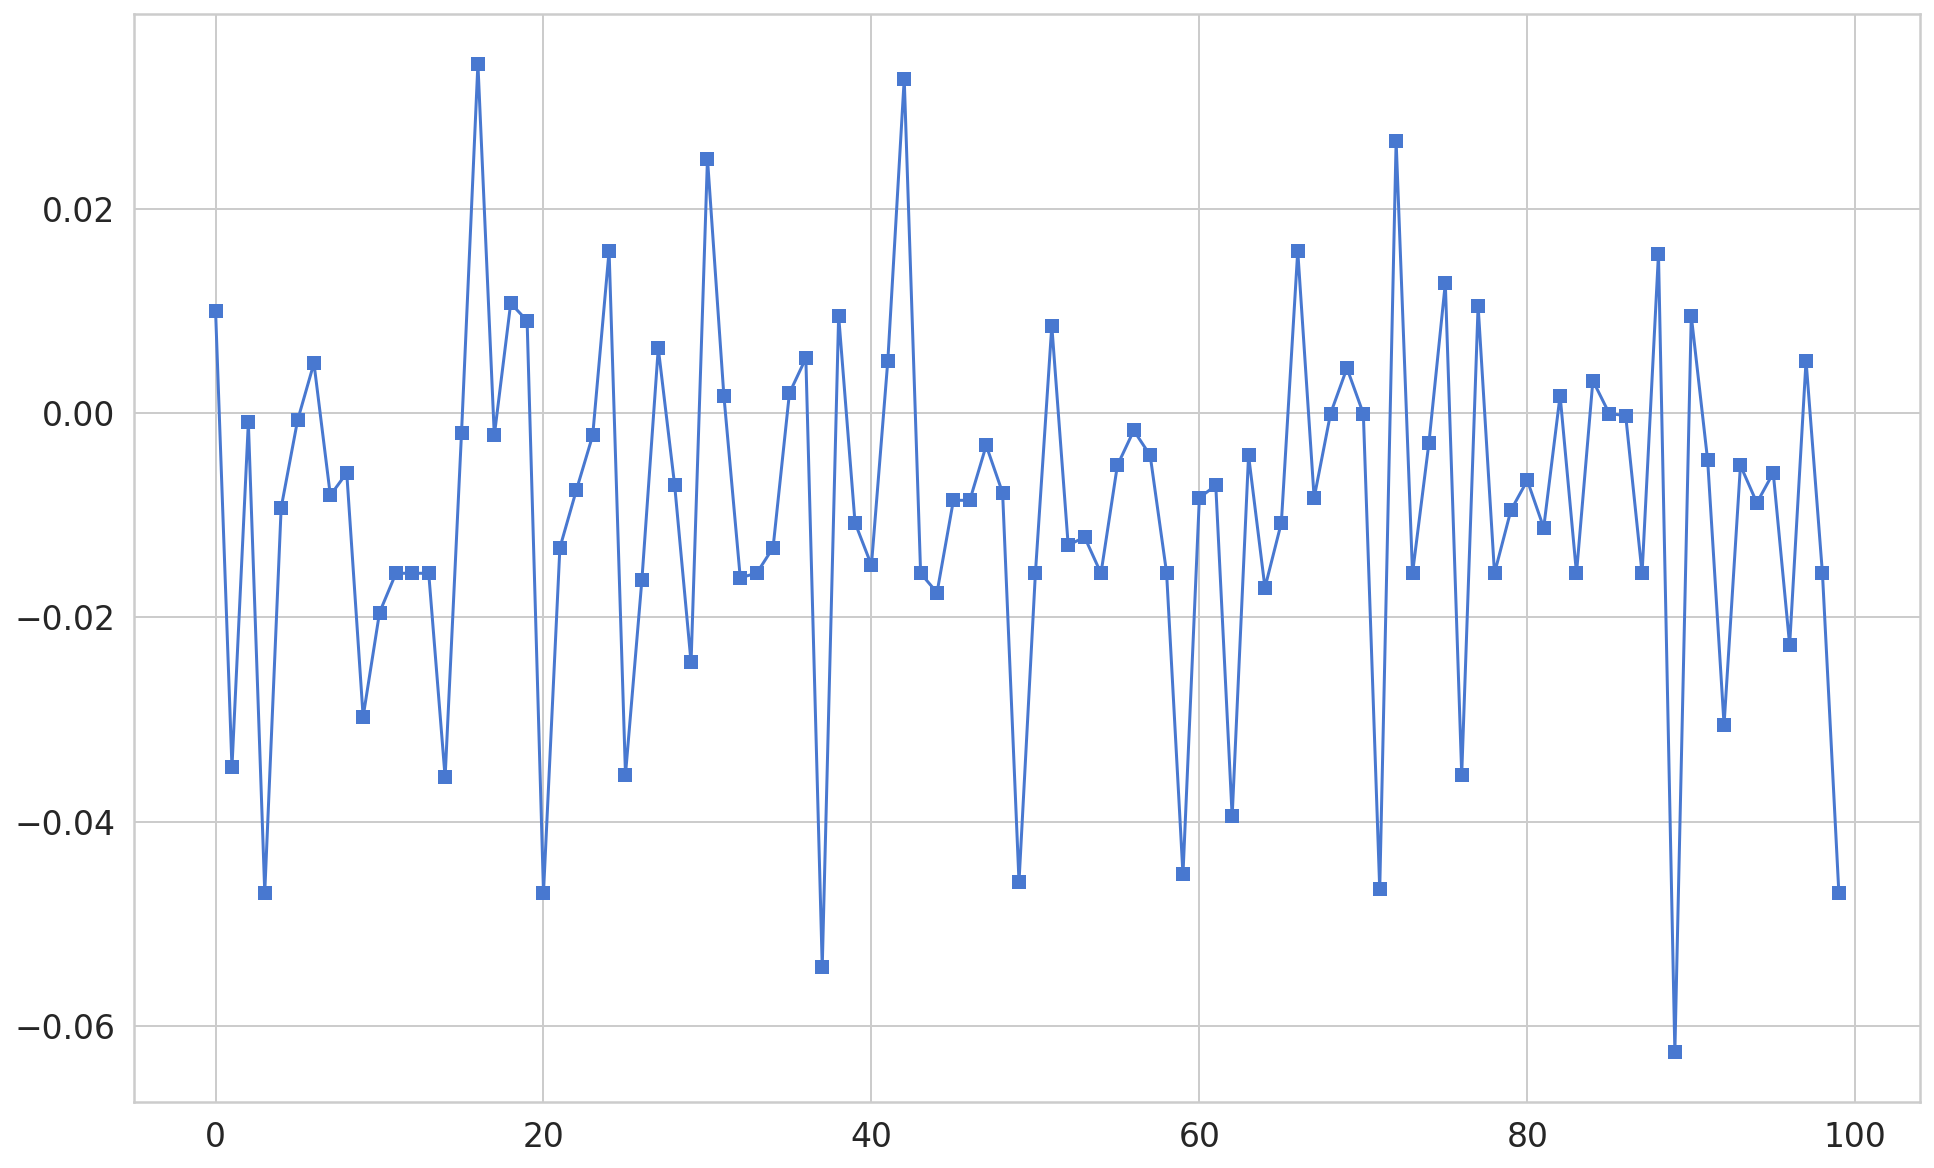

In [ ]:
# 비정상 데이터 100개 확인하여 데이터 양상 확인
plt.plot(abnormal_df.scaled[:100], marker='s')

- 데이터 전처리


In [ ]:
# 방법1. 정상데이터에 비정상데이터를 일부 섞어서 정상비정상 분류?
# 정상과 비정상을 몇대 몇으로 섞을것인가?
# 비정상데이터를 어디에 끼워 넣을 것이간?

# 방법2. 일단 정상데이터를 학습시킨 후 예측까지 수행
# 새로운 데이터로 비정상데이터를 넣어서 예측과 오차나는 정도가 클 때 이상이라고 판단?

In [ ]:
# 결측치 확인
normal_df.isnull().sum()

Normal    0
dtype: int64

- Train, test 나누기
- 8:2

In [ ]:
# 학습데이터 80%
train_size = int(len(normal_df['scaled']) * 0.8)
# 테스트데이터 나머지20%
test_size = len(normal_df['scaled']) - train_size
train, test = normal_df['scaled'].iloc[0:train_size], normal_df['scaled'].iloc[train_size:]
print(len(train), len(test))

81460 20365


In [ ]:
train

0       -0.049316
1       -0.019775
2       -0.045898
3       -0.059082
4       -0.036377
           ...   
81455   -0.052734
81456   -0.072510
81457   -0.029541
81458   -0.044189
81459   -0.024170
Name: scaled, Length: 81460, dtype: float64

In [ ]:
test.shape

(20365,)

In [ ]:
# test 인덱스 변경
test.index = range(len(test))

In [ ]:
test

0       -0.028076
1       -0.030762
2       -0.067871
3       -0.003845
4       -0.032959
           ...   
20360   -0.044678
20361   -0.025635
20362   -0.058350
20363   -0.036377
20364   -0.039307
Name: scaled, Length: 20365, dtype: float64

In [ ]:
# 데이터 세팅함수
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(X[i+time_steps])
        # y는 time_step 다음 값으로 설정
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 80 # 20, 40, 80 등으로 다양하게 시도해봄 -> 결과에 유의미한 차이 없었음

X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

print(X_train.shape, y_train.shape)

(81380, 80) (81380,)


In [ ]:
X_train.shape

(81380, 80)

In [ ]:
y_train.shape

(81380,)

In [ ]:
# LSTM이 요구하는 shape으로 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(81380, 80, 1)

# 정상데이터만 넣어서 학습

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30,  # epoch 30, 100 시도 -> 별 차이 없음
    batch_size=20, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/30
3663/3663 [==============================] - 22s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 2/30
3663/3663 [==============================] - 21s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 3/30
3663/3663 [==============================] - 22s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 4/30
3663/3663 [==============================] - 21s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 5/30
3663/3663 [==============================] - 21s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 6/30
3663/3663 [==============================] - 23s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 7/30
3663/3663 [==============================] - 22s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 8/30
3663/3663 [==============================] - 22s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 9/30
3663/3663 [==============================] - 22s 6ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 10/30
3663/3663 [==============================] - 21s 6ms/step - l

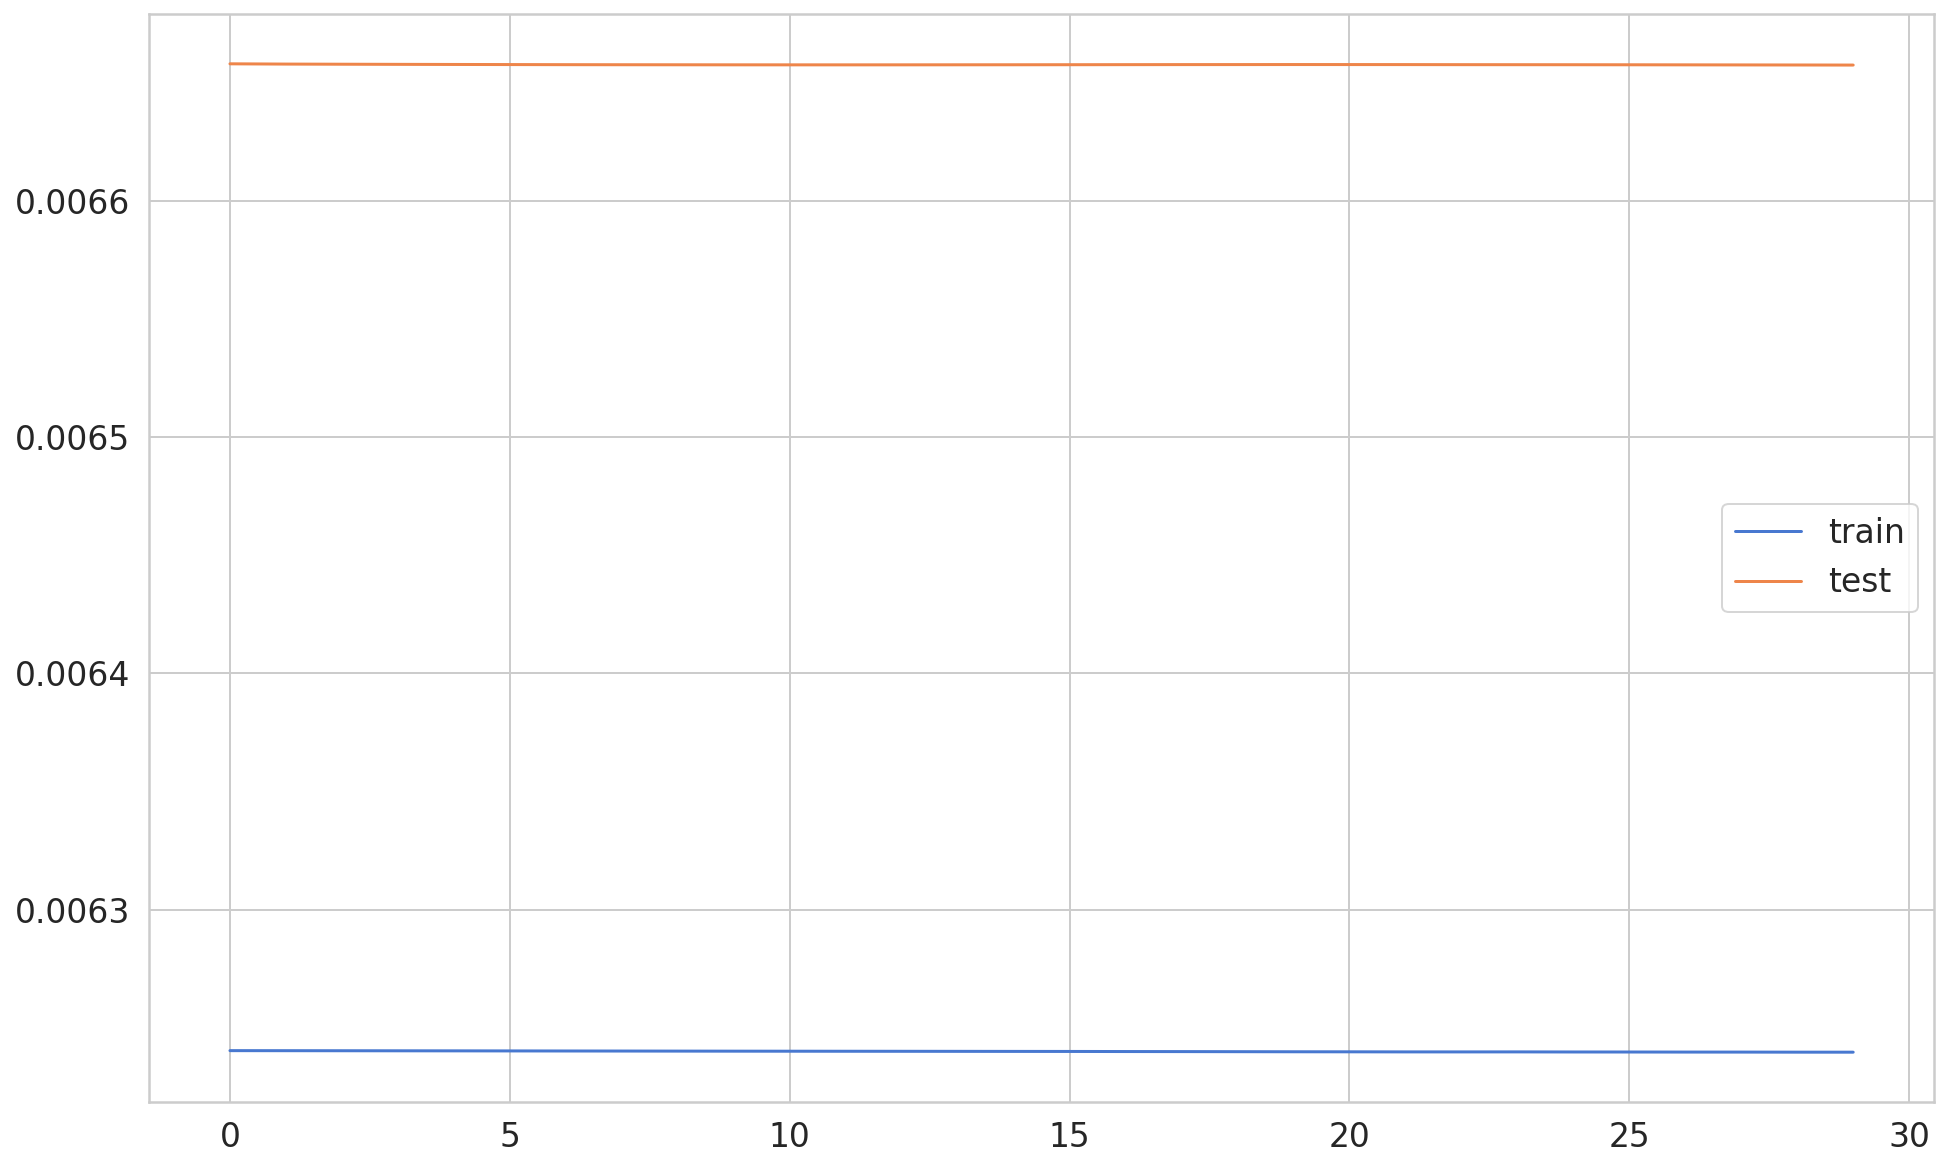

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
# reshape필요
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

(20285, 1)

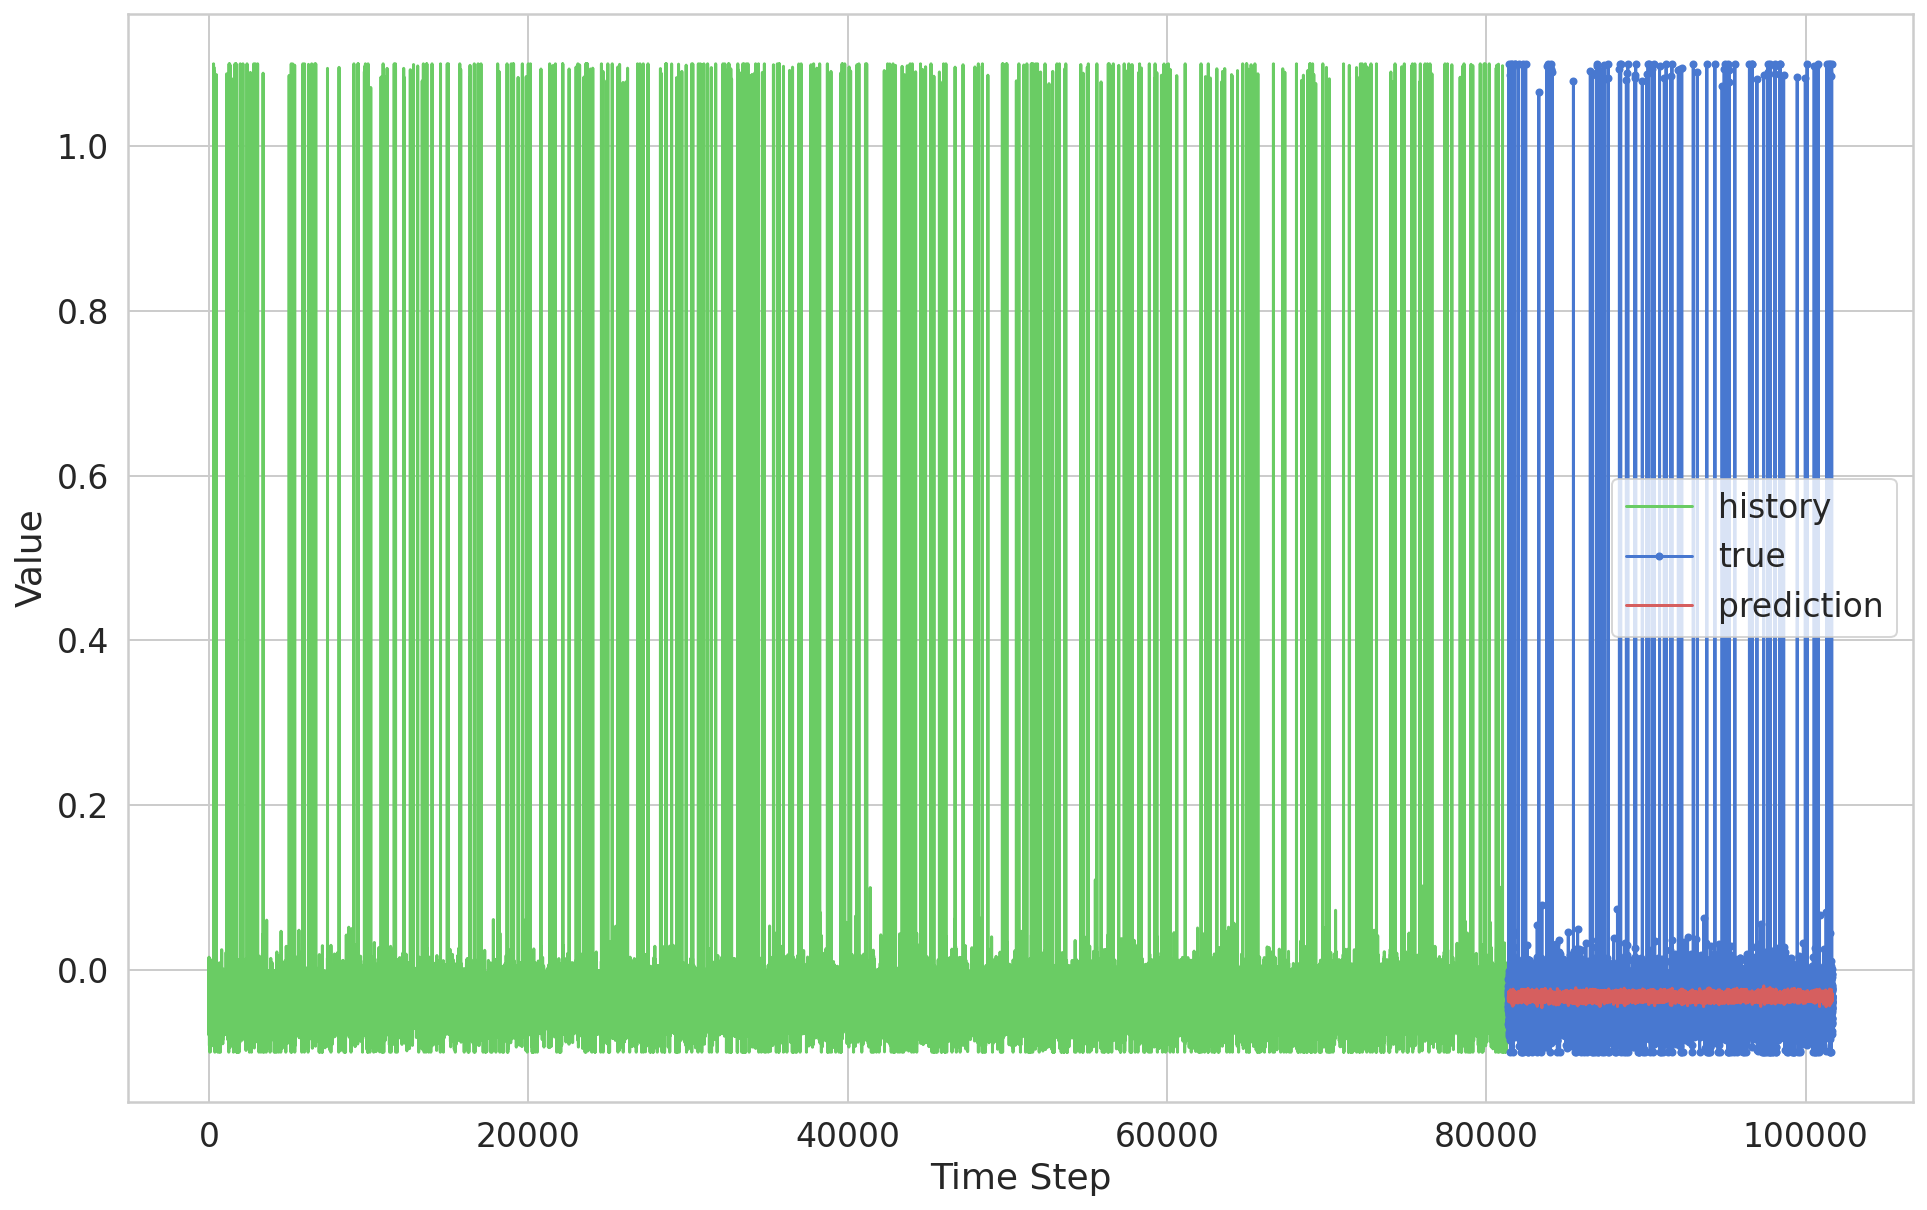

In [ ]:
# 예측값 실제값 그래프 확인
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

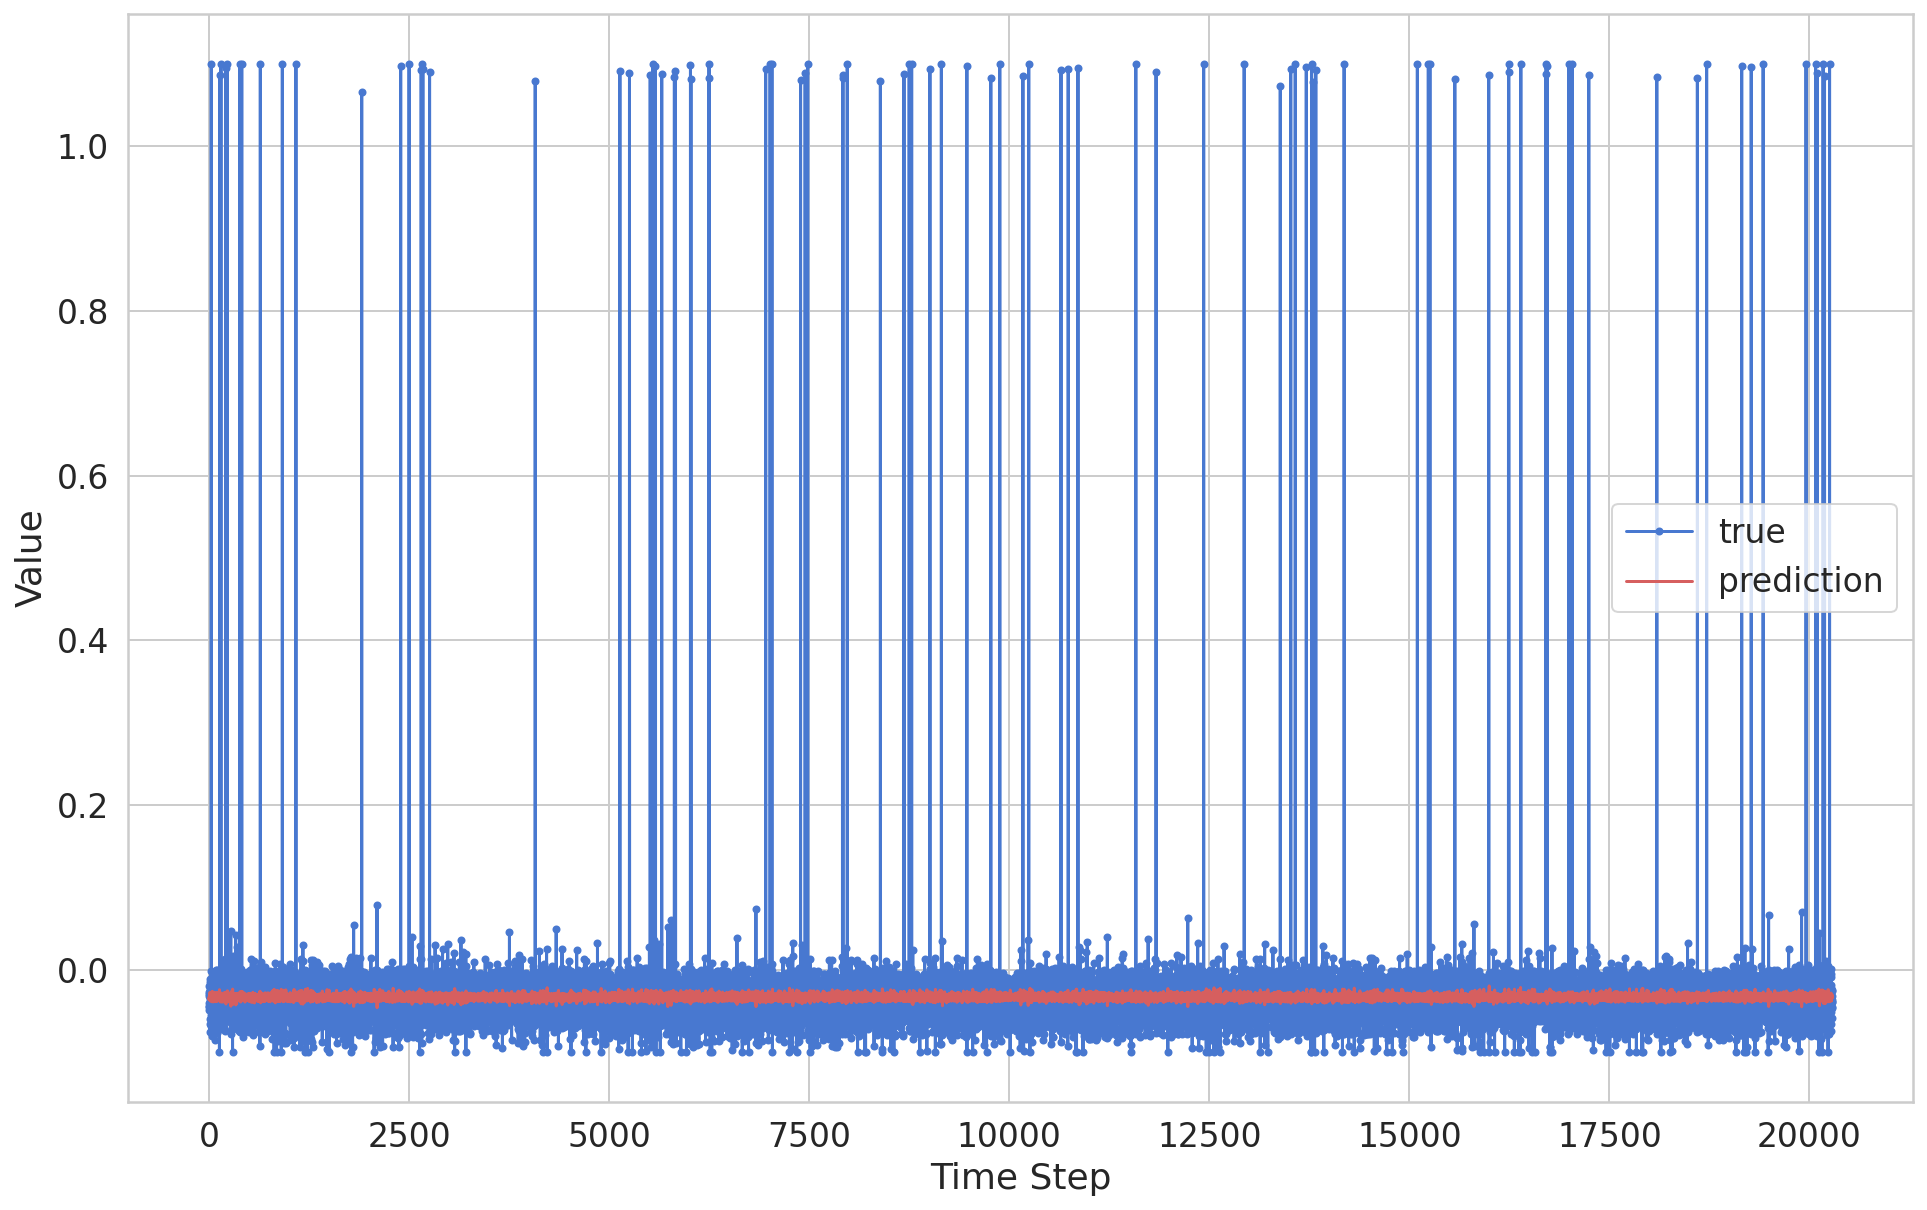

In [ ]:
# 예측값과 실제값 비교
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

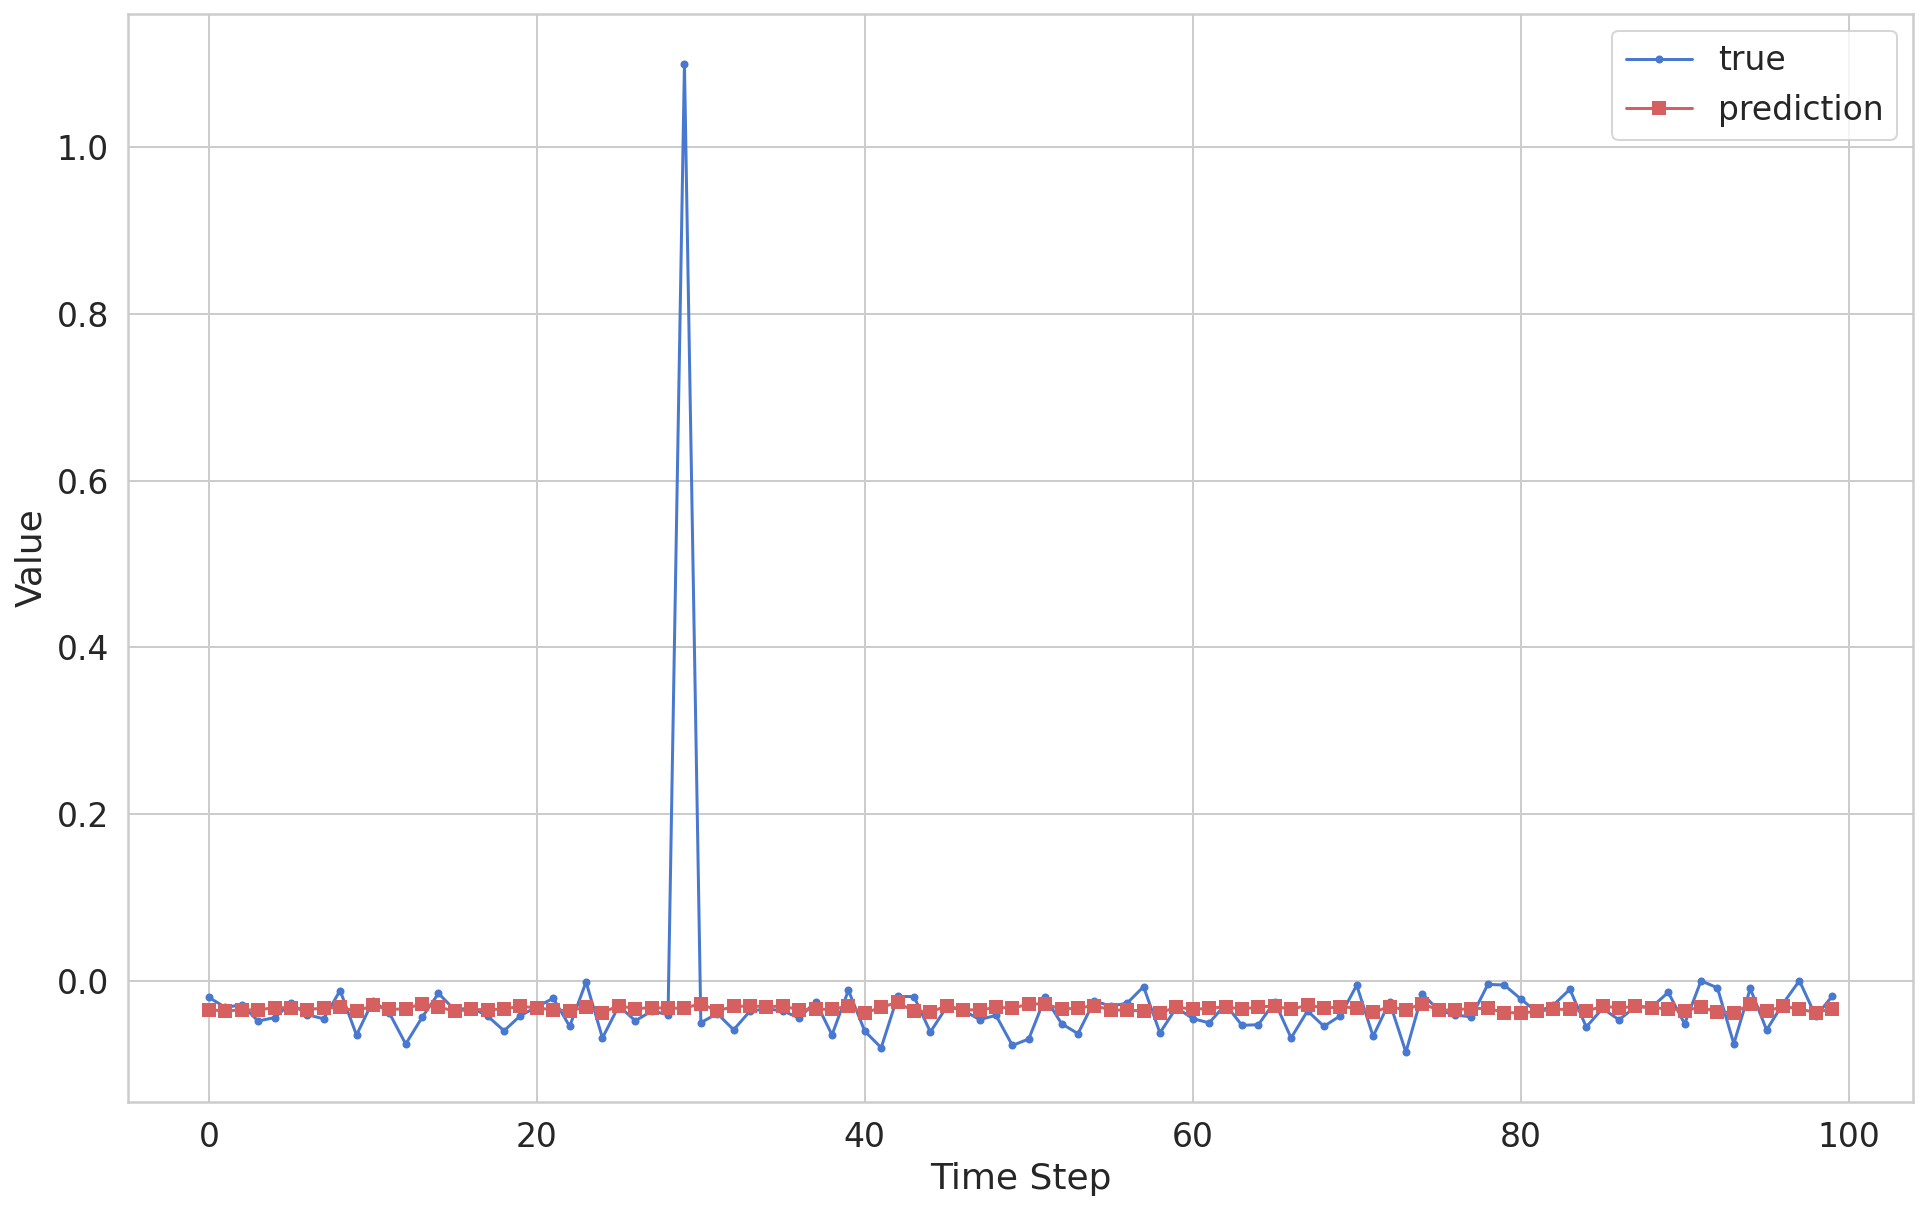

In [ ]:
# 더 확대
plt.plot(y_test[:100], marker='.', label="true")
plt.plot(y_pred[:100], 'r', marker='s', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Prophet
- 페북에서 만든 시계열데이터 분석 모델 이용

In [ ]:
!pip install fbprophet 

In [ ]:
# 모듈 가져오기
import warnings
# 경고 무시처리
warnings.filterwarnings('ignore')

# 기본 
import numpy as np
import pandas as pd

# 예측용 
from fbprophet import Prophet

# 시간처리
from datetime import datetime

In [ ]:
train.shape

(81460,)

In [ ]:
# prophet 모델에서 요구하는 형식으로 날짜가 필요해서 임의로 날짜 부여
date=pd.date_range(start='2000-10-01', periods=len(train))
date.shape

(81460,)

In [ ]:
# prophet을 이용하여 시즌 분석, 계절 분석 등 시간 관점에서 분석
# 데이터를 맞는 형태로 구성
# 데이터: DS에 시간, Y에는 수치 데이터(예측하고자 하는)로 df 구성
dic = {
    'ds' : date.values,
    'y' : train.values
}
df = pd.DataFrame(dic)
df.head(2)
# 인덱스쪽을 0,1,2,.... 나오게 처리
df.reset_index(inplace=True, drop=True)

df.head(2)

,ds,y
0,2000-10-01,-0.049316
1,2000-10-02,-0.019775


In [ ]:
# 예측 모델 생성
# 주기성을 일단위로 설정
model = Prophet(daily_seasonality=True)
# 학습
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
test.shape

(20365,)

In [ ]:
# 예측기간 설정

# 실제 예측할 기간만 부여하면 알아서 훈련했던 기간부터 적용하여 데이터가 없는 부분부터 추가된 기간까지 예측해서 데이터 생성
fu = model.make_future_dataframe(periods=365)
fu.tail(2)

,ds
81823,2224-10-10
81824,2224-10-11


In [ ]:
# 예측
forecast = model.predict(fu)

forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-10-01,-0.046077,-0.135799,0.076826,-0.046077,-0.046077,0.015471,0.015471,0.015471,0.012952,0.012952,0.012952,0.000051,0.000051,0.000051,0.002468,0.002468,0.002468,0.0,0.0,0.0,-0.030606
1,2000-10-02,-0.046077,-0.127416,0.069979,-0.046077,-0.046077,0.015651,0.015651,0.015651,0.012952,0.012952,0.012952,0.000246,0.000246,0.000246,0.002453,0.002453,0.002453,0.0,0.0,0.0,-0.030426


In [ ]:
# yhat
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].head(2)

,ds,yhat_lower,yhat_upper,yhat
0,2000-10-01,-0.135799,0.076826,-0.030606
1,2000-10-02,-0.127416,0.069979,-0.030426


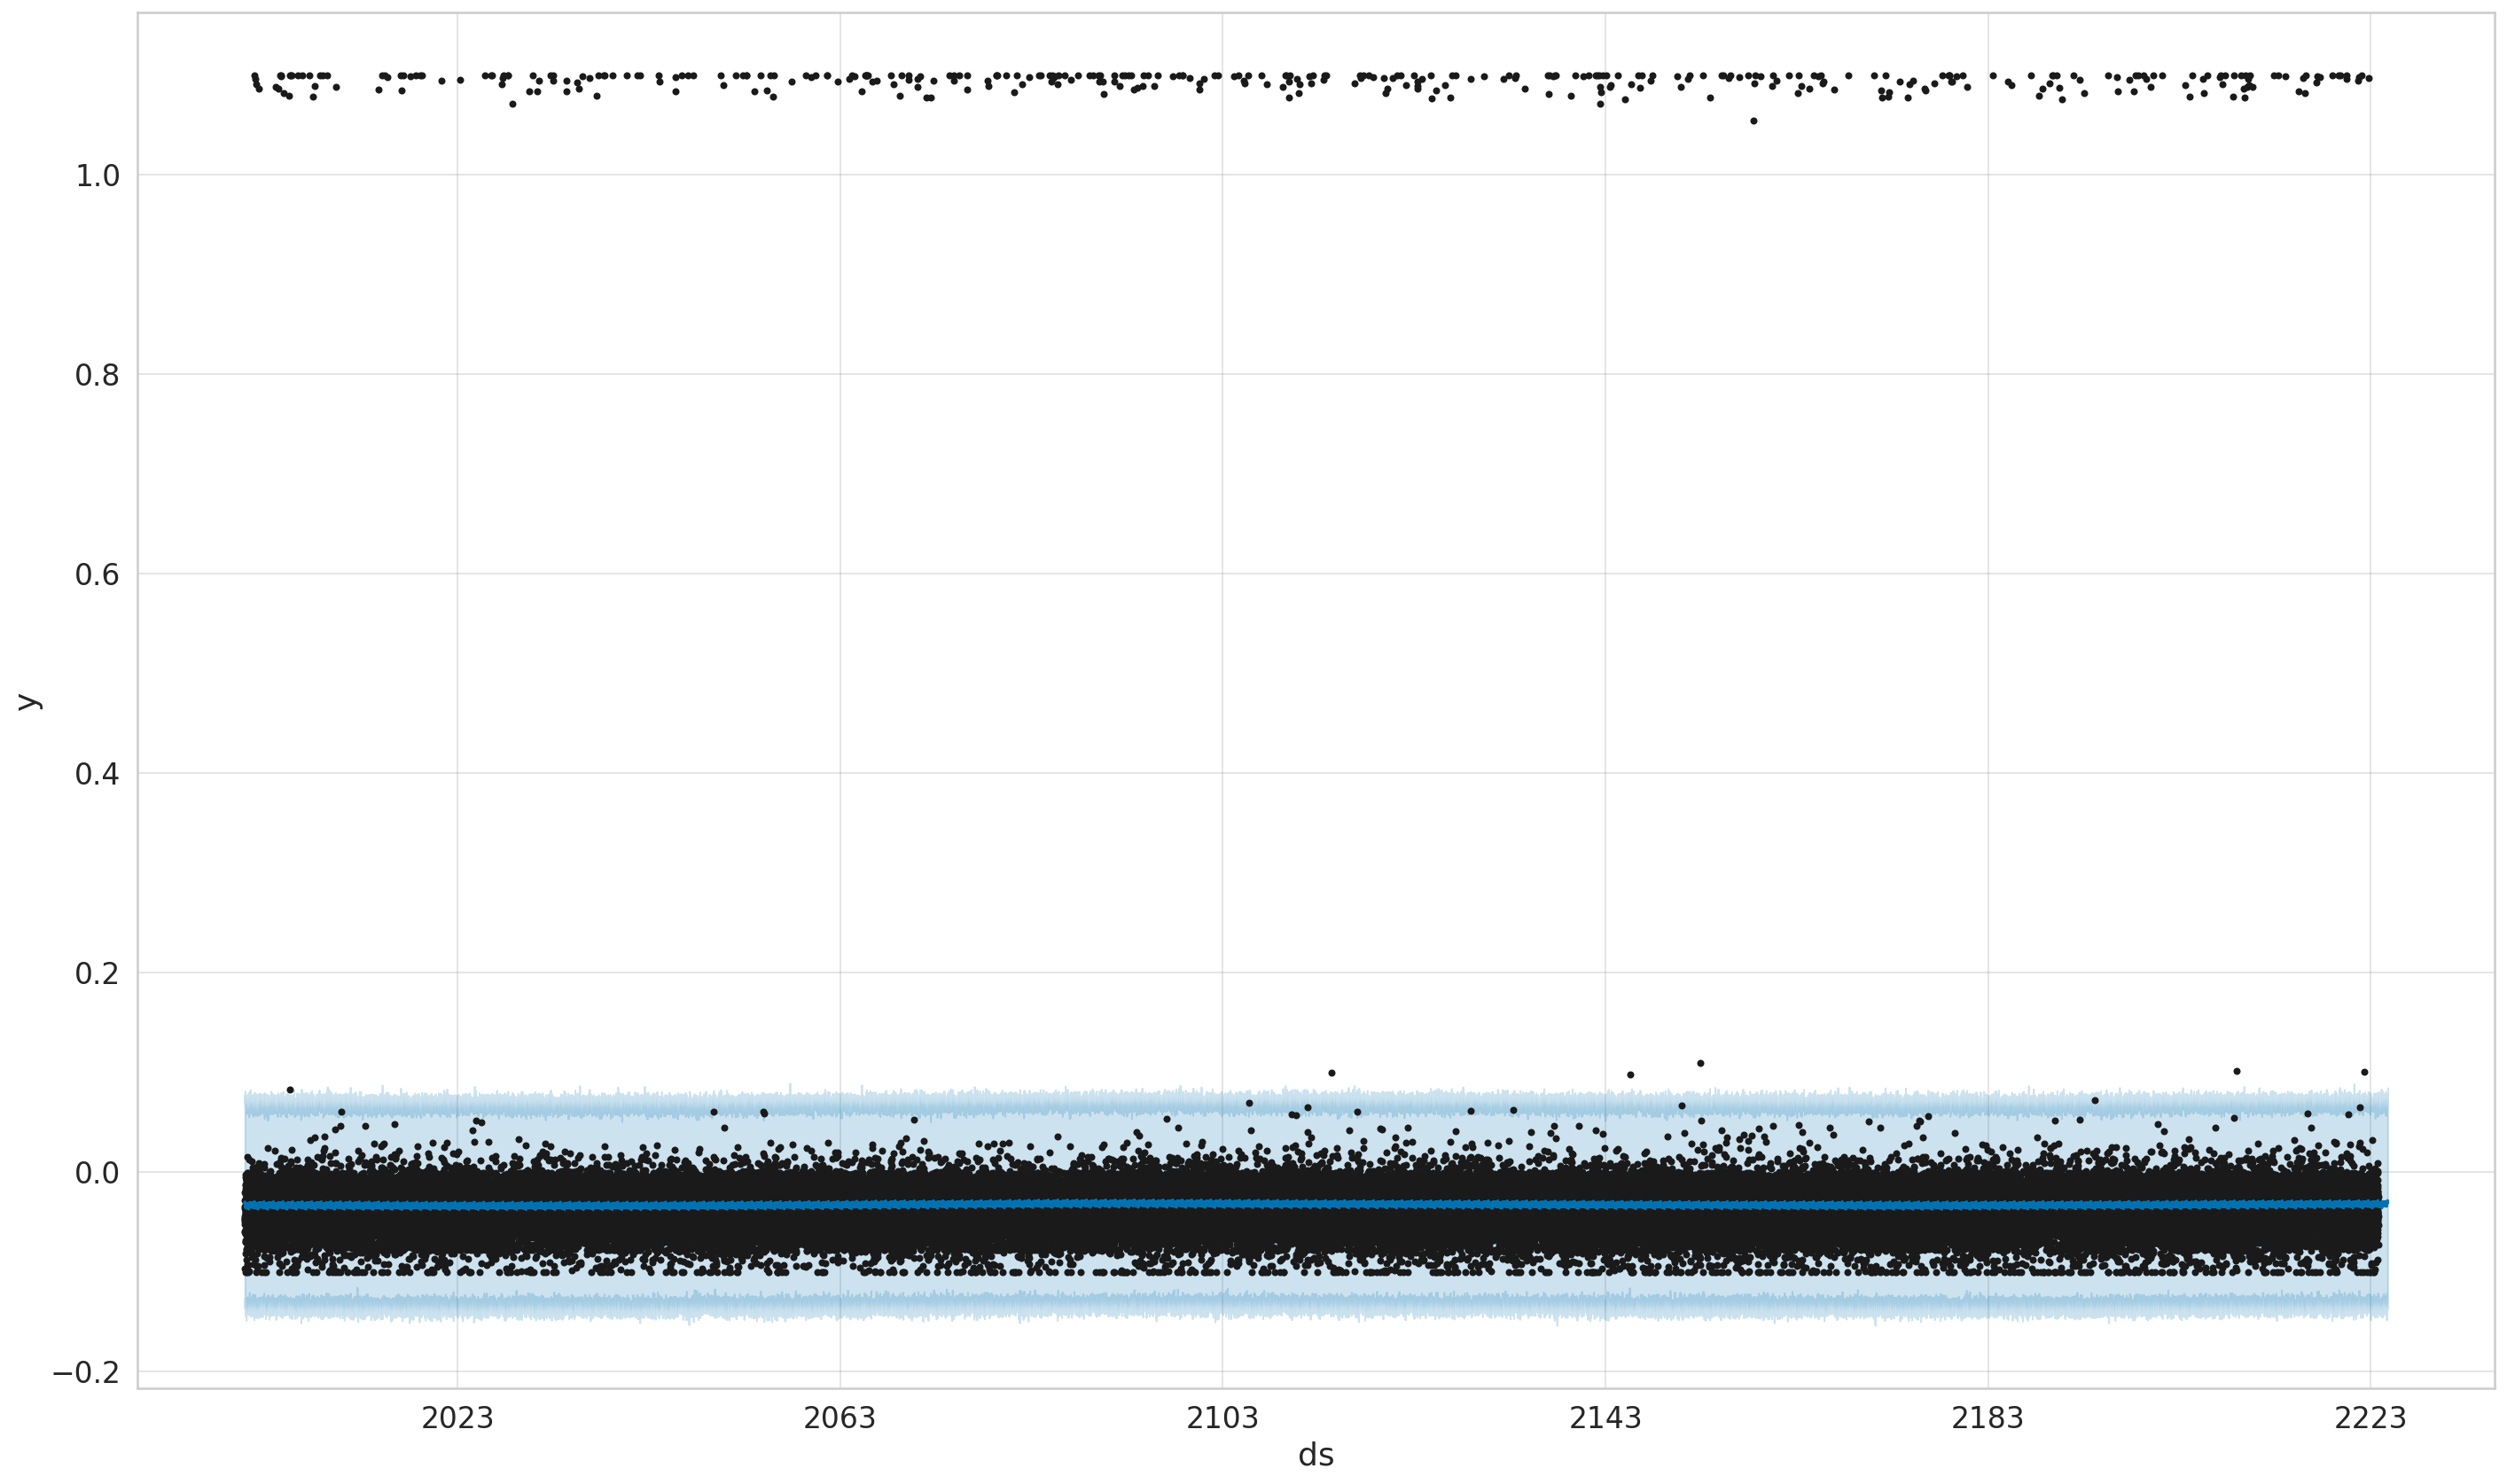

<Figure size 1440x864 with 0 Axes>

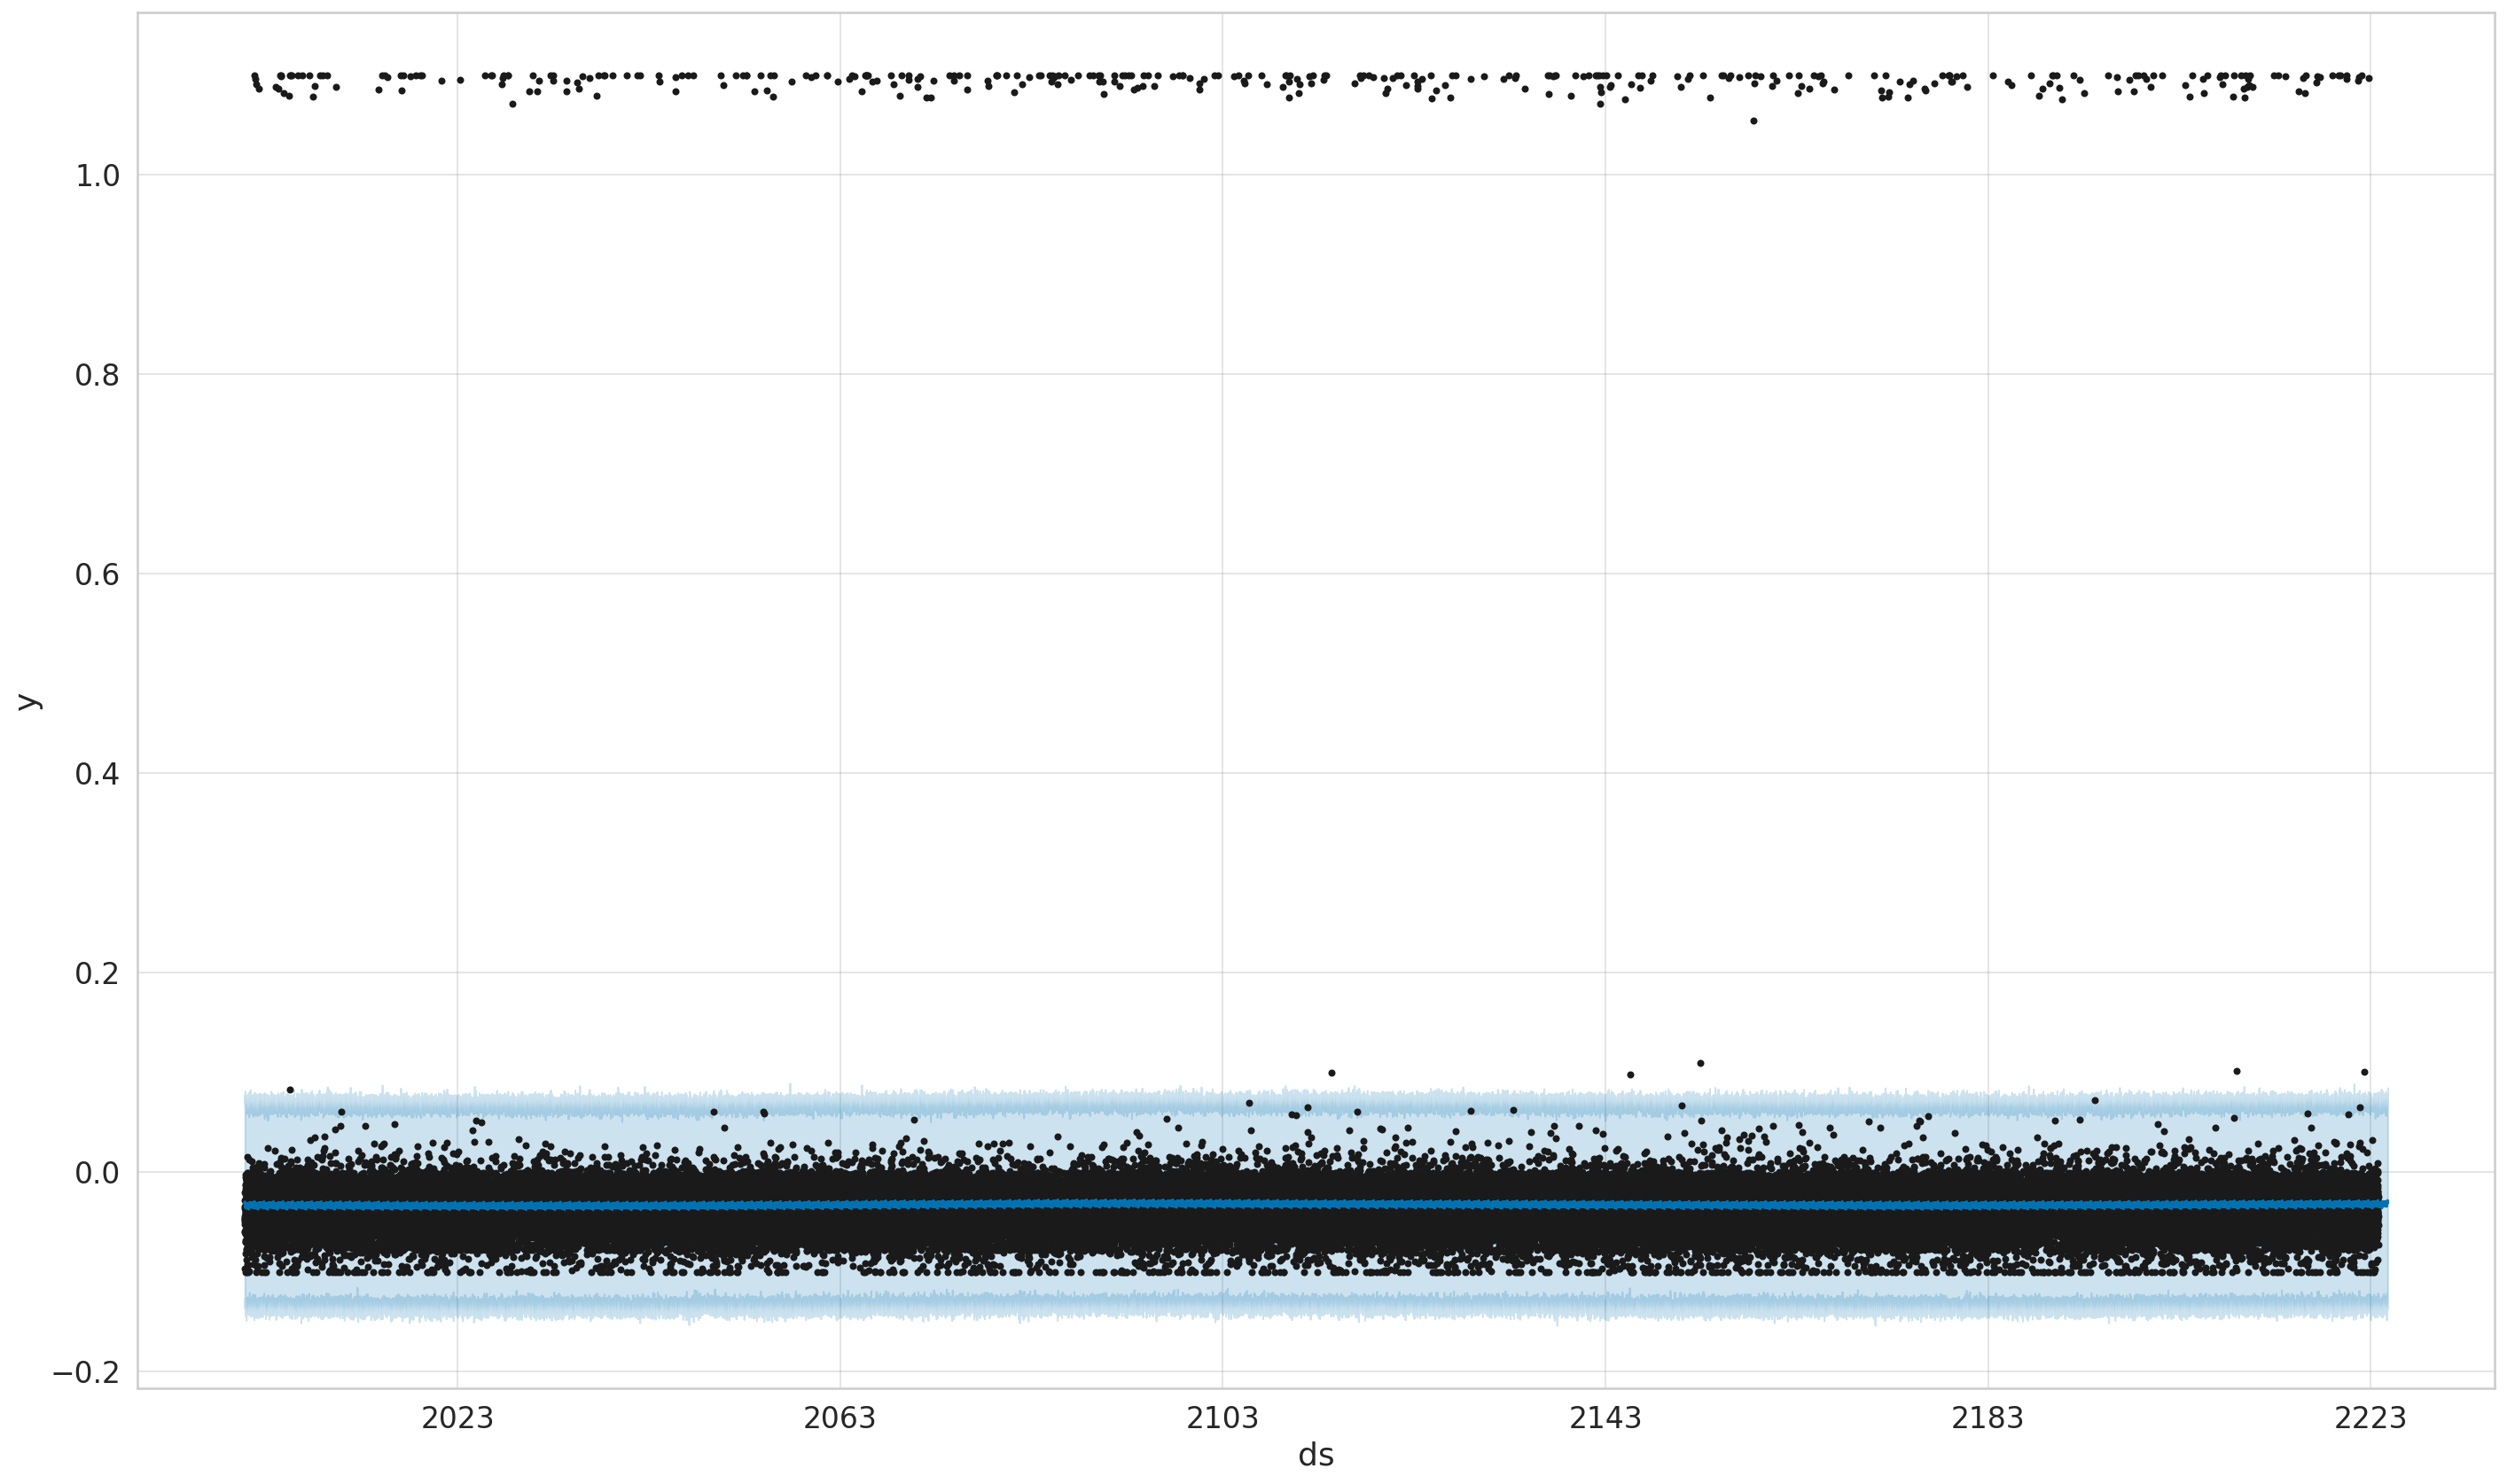

In [ ]:
# 선형 그래프, 예측
plt.figure(figsize=(20,12))
model.plot(forecast, figsize=(20,12))

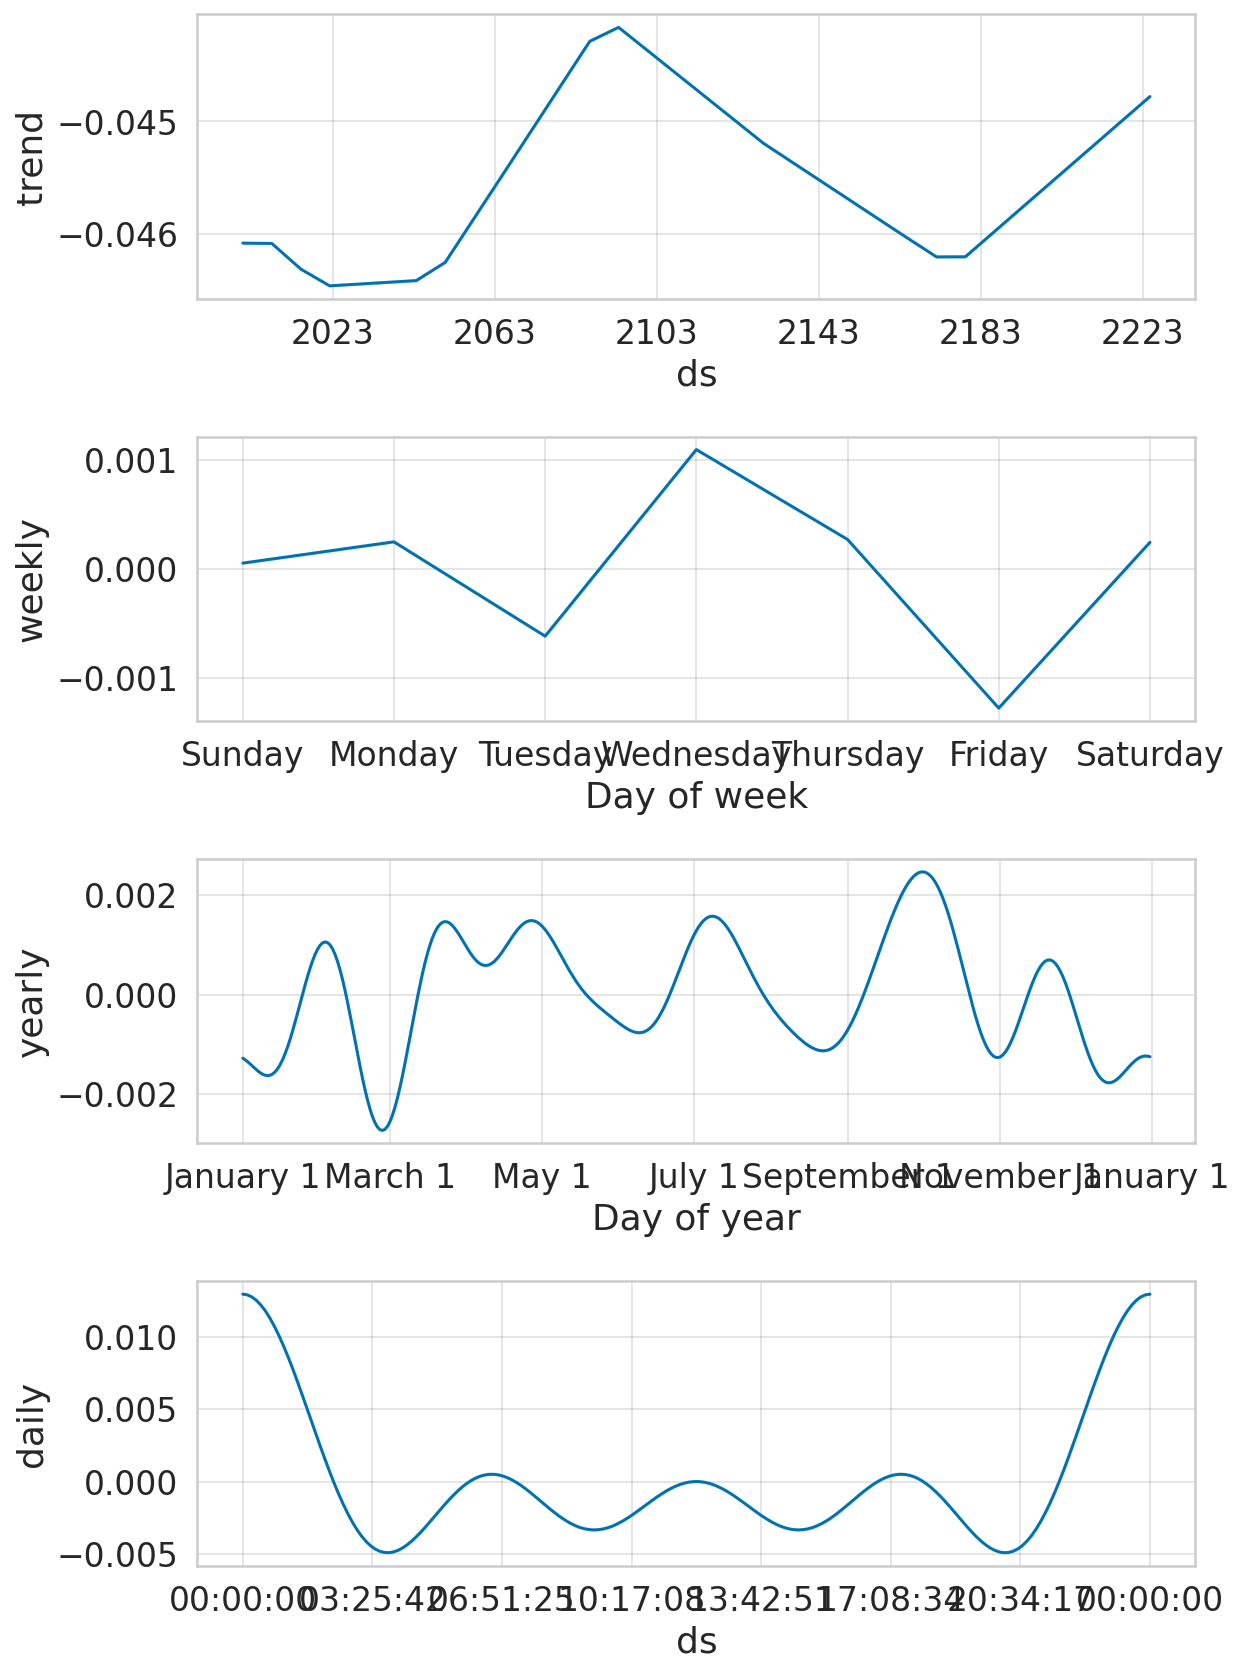

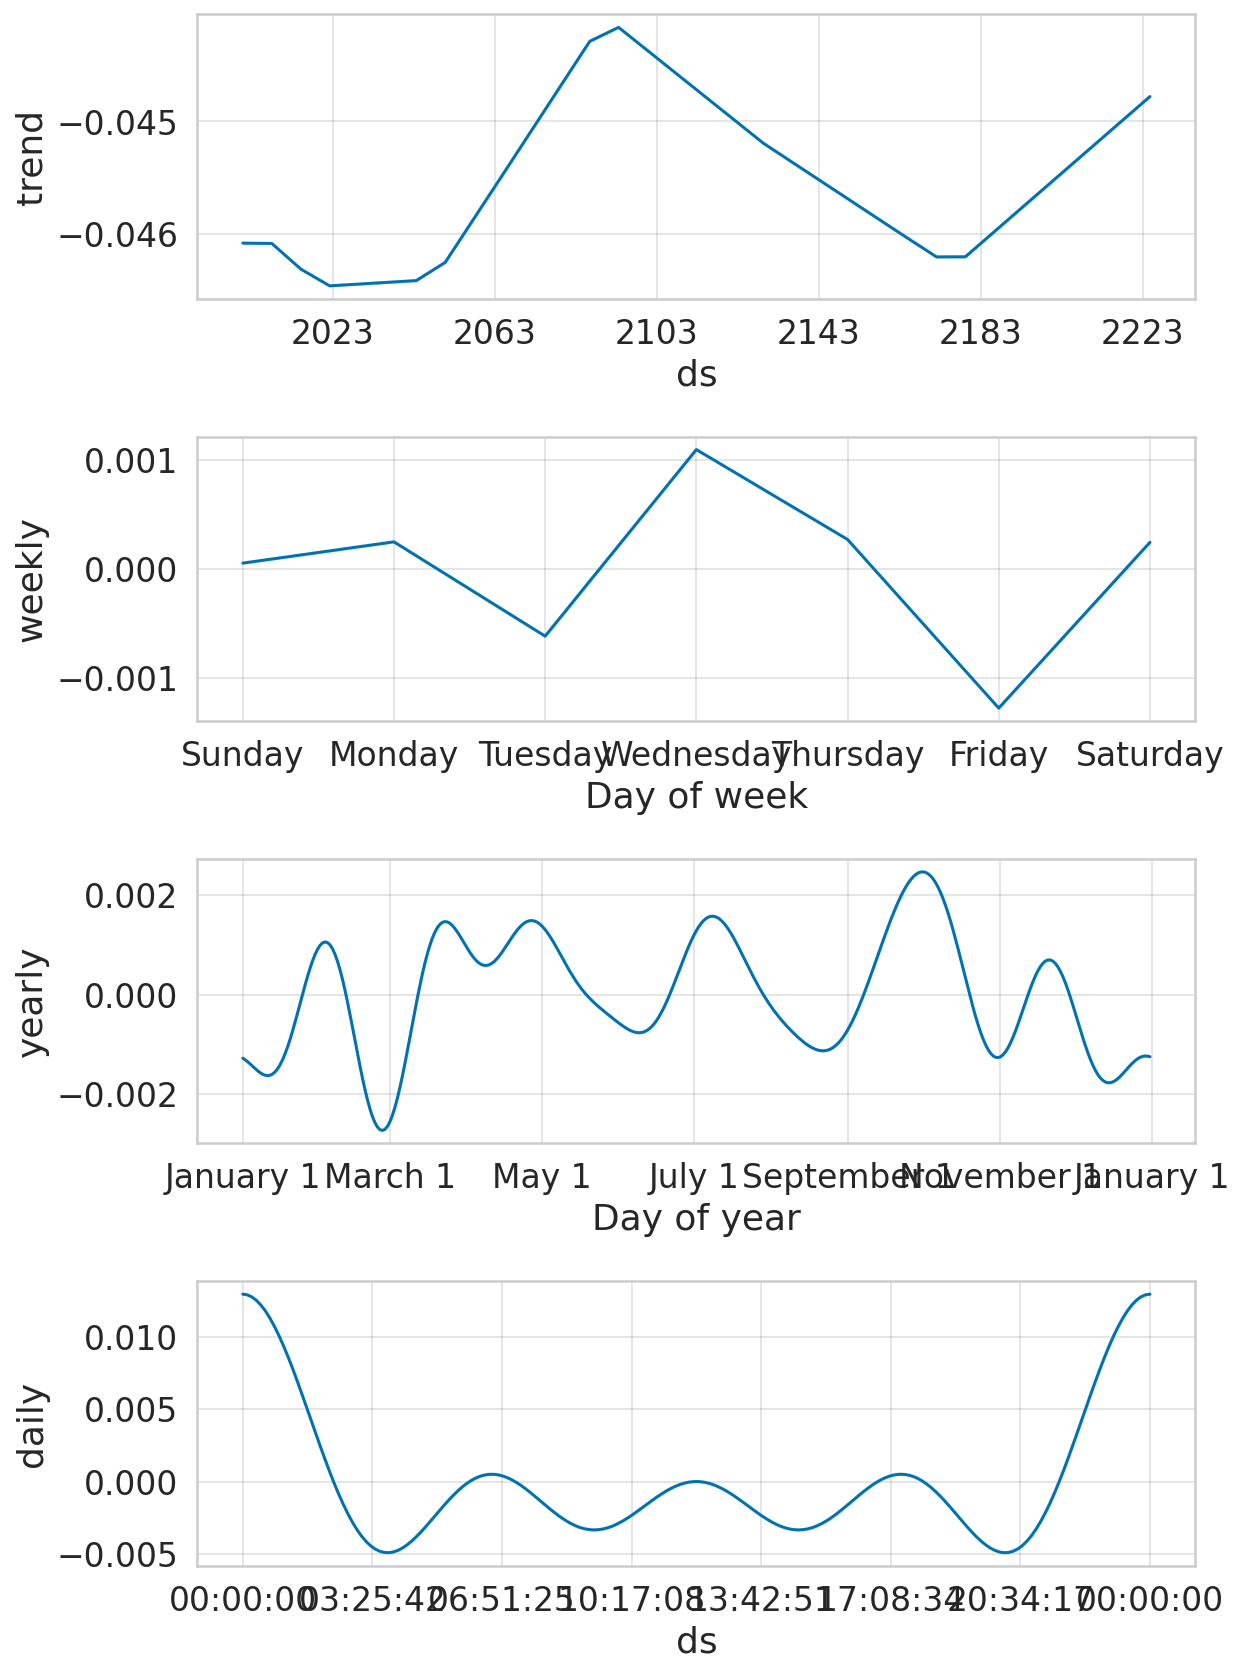

In [ ]:
model.plot_components(forecast)

# 1 이상, -1 이하 데이터 날린 후 예측

In [ ]:
tmp = normal_df[normal_df['Normal'] < 0.1]

In [ ]:
tmp = tmp[tmp.Normal > -0.1]

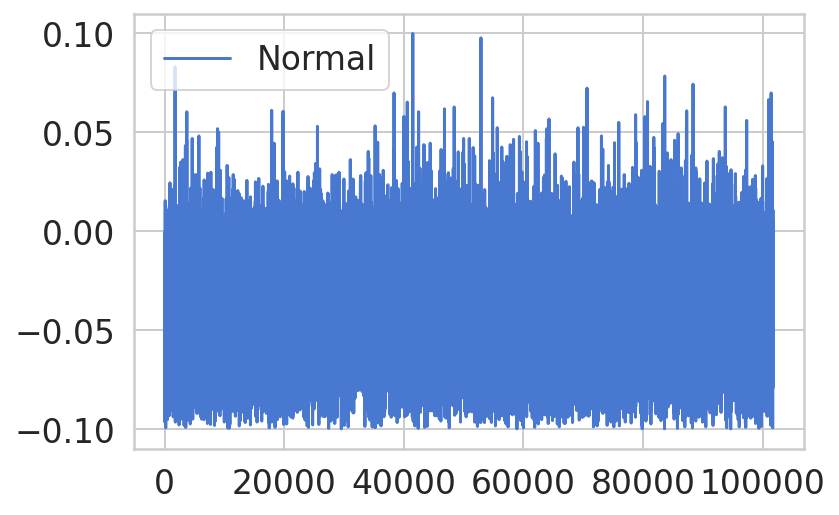

In [ ]:
tmp.plot()

In [ ]:
# 학습데이터 80%
train_size = int(len(tmp.Normal) * 0.8)
# 테스트데이터 나머지20%
test_size = len(tmp.Normal) - train_size
train, test = tmp.Normal.iloc[0:train_size], tmp.Normal.iloc[train_size:]
print(len(train), len(test))

80711 20178


In [ ]:
train.index=range(len(train))

In [ ]:
train[70:80]

70   -0.061279
71   -0.029541
72   -0.035400
73   -0.016602
74   -0.031311
75   -0.039062
76   -0.036377
77   -0.028809
78   -0.020020
79   -0.000732
Name: Normal, dtype: float64

In [ ]:
test.index = range(len(test))

In [ ]:
train

0       -0.049316
1       -0.019775
2       -0.045898
3       -0.059082
4       -0.036377
           ...   
80706   -0.020752
80707   -0.048584
80708   -0.027588
80709   -0.045898
80710   -0.036133
Name: Normal, Length: 80711, dtype: float64

In [ ]:
test

0       -0.029297
1       -0.045410
2       -0.025879
3       -0.054688
4       -0.000488
           ...   
20173   -0.044678
20174   -0.025635
20175   -0.058350
20176   -0.036377
20177   -0.039307
Name: Normal, Length: 20178, dtype: float64

In [ ]:
# 데이터 세팅함수
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(X[i+time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 40

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

print(X_train.shape, y_train.shape)

(80671, 40) (80671,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, X_test.shape

((80671, 40, 1), (20138, 40, 1))

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=20, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=20, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/30
3631/3631 [==============================] - 15s 4ms/step - loss: 3.6848e-04 - val_loss: 3.8479e-04
Epoch 2/30
3631/3631 [==============================] - 14s 4ms/step - loss: 3.6466e-04 - val_loss: 3.8250e-04
Epoch 3/30
3631/3631 [==============================] - 14s 4ms/step - loss: 3.6426e-04 - val_loss: 3.8215e-04
Epoch 4/30
3631/3631 [==============================] - 14s 4ms/step - loss: 3.6406e-04 - val_loss: 3.8195e-04
Epoch 5/30
3631/3631 [==============================] - 14s 4ms/step - loss: 3.6395e-04 - val_loss: 3.8187e-04
Epoch 6/30
3631/3631 [==============================] - 15s 4ms/step - loss: 3.6390e-04 - val_loss: 3.8181e-04
Epoch 7/30
3631/3631 [==============================] - 15s 4ms/step - loss: 3.6385e-04 - val_loss: 3.8180e-04
Epoch 8/30
3631/3631 [==============================] - 14s 4ms/step - loss: 3.6381e-04 - val_loss: 3.8179e-04
Epoch 9/30
3631/3631 [==============================] - 14s 4ms/step - loss: 3.6377e-04 - val_loss: 3.8181e-04
E

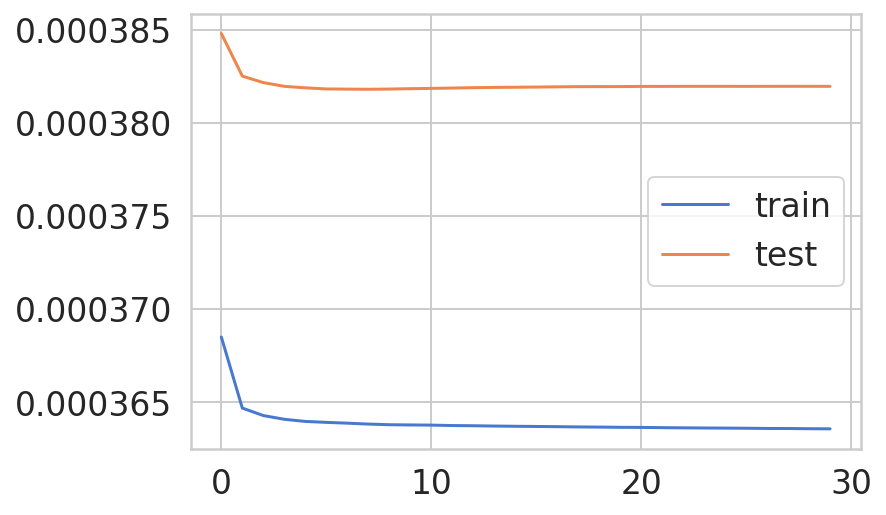

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

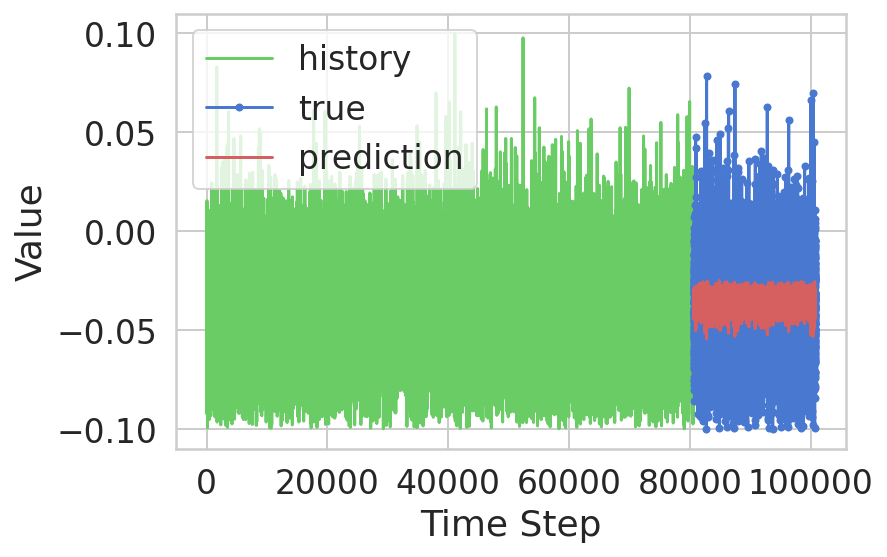

In [ ]:
# 예측값 실제값 그래프 확인
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

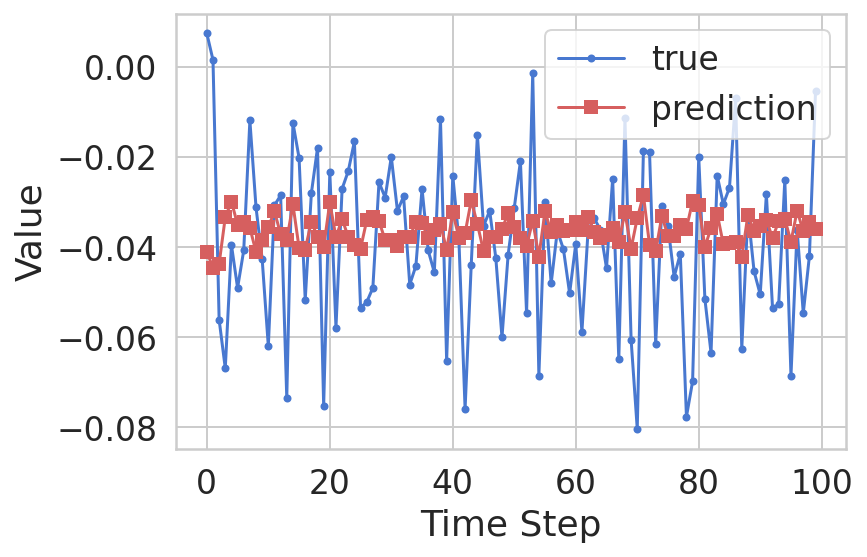

In [ ]:
# 더 확대
plt.plot(y_test[:100], marker='.', label="true")
plt.plot(y_pred[:100], 'r', marker='s', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
!nvidia-smi

Sat Oct 10 05:17:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------